In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
import tensorflow_datasets as tfds

imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling imdb_reviews-train.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling imdb_reviews-test.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling imdb_reviews-unsupervised.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to C:\Users\Andrew\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


In [14]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s, l in train_data:
    training_sentences.append(s.numpy().decode('utf8'))
    training_labels.append(l.numpy())

for s, l in test_data:
    testing_sentences.append(s.numpy().decode('utf8'))
    testing_labels.append(l.numpy())

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [24]:
testing_labels_final

array([1, 1, 0, ..., 0, 1, 1], dtype=int64)

In [15]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [16]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])


def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


print(decode_review(padded[3]))
print(training_sentences[3])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? this is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with its own business as you <OOV> into a big arm chair and <OOV> for a couple of hours wonderful performances from cher and nicolas cage as always gently row the plot along there are no <OOV> to cross no dangerous waters just a warm and witty <OOV> through new york life at its best a family film in every sense and one that deserves the praise it received
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.


In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 flatten_2 (Flatten)         (None, 1920)              0         
                                                                 
 dense_4 (Dense)             (None, 6)                 11526     
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [18]:
num_epochs = 10
model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 5s 6ms/step - loss: 0.5673 - accuracy: 0.7207 - val_loss: 0.4441 - val_accuracy: 0.8413
Epoch 2/10
782/782 [==============================] - 5s 6ms/step - loss: 0.3380 - accuracy: 0.8958 - val_loss: 0.4092 - val_accuracy: 0.8378
Epoch 3/10
782/782 [==============================] - 5s 6ms/step - loss: 0.1850 - accuracy: 0.9606 - val_loss: 0.4417 - val_accuracy: 0.8321
Epoch 4/10
782/782 [==============================] - 5s 6ms/step - loss: 0.1108 - accuracy: 0.9819 - val_loss: 0.4720 - val_accuracy: 0.8306
Epoch 5/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0781 - accuracy: 0.9875 - val_loss: 0.5347 - val_accuracy: 0.8266
Epoch 6/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0630 - accuracy: 0.9892 - val_loss: 0.5725 - val_accuracy: 0.8276
Epoch 7/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0548 - accuracy: 0.9901 - val_loss: 0.5919 - val_accuracy: 0.8270
Epoch 

In [19]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)  # shape: (vocab_size, embedding_dim)

(10000, 16)


In [20]:
# import io
#
# out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
# out_m = io.open('meta.tsv', 'w', encoding='utf-8')
# for word_num in range(1, vocab_size):
#   word = reverse_word_index[word_num]
#   embeddings = weights[word_num]
#   out_m.write(word + "\n")
#   out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
# out_v.close()
# out_m.close()

In [21]:
sentence = "I really think this is amazing. honest."
sequence = tokenizer.texts_to_sequences([sentence])
print(sequence)

[[11, 64, 102, 12, 7, 478, 1200]]


# Sarcasm dataset

In [25]:
import json

with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [28]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = 20000

In [30]:
len(sentences)

26709

In [31]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [35]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [36]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [58]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAvgPool2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

ValueError: Input 0 of layer "global_average_pooling2d" is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: (None, 100, 16)

In [59]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 16)           160000    
                                                                 
 flatten_3 (Flatten)         (None, 1600)              0         
                                                                 
 dense_14 (Dense)            (None, 128)               204928    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                                 
Total params: 373,249
Trainable params: 373,249
Non-tr

In [60]:
num_epochs = 20
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/20
625/625 - 3s - loss: 0.0016 - accuracy: 0.9995 - val_loss: 1.5756 - val_accuracy: 0.8305 - 3s/epoch - 5ms/step
Epoch 2/20
625/625 - 3s - loss: 0.0010 - accuracy: 0.9997 - val_loss: 1.5496 - val_accuracy: 0.8343 - 3s/epoch - 5ms/step
Epoch 3/20
625/625 - 3s - loss: 0.0016 - accuracy: 0.9995 - val_loss: 1.4460 - val_accuracy: 0.8290 - 3s/epoch - 5ms/step
Epoch 4/20
625/625 - 3s - loss: 0.0010 - accuracy: 0.9997 - val_loss: 1.5486 - val_accuracy: 0.8265 - 3s/epoch - 5ms/step
Epoch 5/20
625/625 - 3s - loss: 8.5400e-04 - accuracy: 0.9997 - val_loss: 1.6605 - val_accuracy: 0.8316 - 3s/epoch - 5ms/step
Epoch 6/20
625/625 - 3s - loss: 7.4074e-04 - accuracy: 0.9997 - val_loss: 1.8455 - val_accuracy: 0.8269 - 3s/epoch - 5ms/step
Epoch 7/20
625/625 - 3s - loss: 8.8003e-04 - accuracy: 0.9998 - val_loss: 1.8611 - val_accuracy: 0.8301 - 3s/epoch - 5ms/step
Epoch 8/20
625/625 - 3s - loss: 0.0016 - accuracy: 0.9995 - val_loss: 1.7736 - val_accuracy: 0.8222 - 3s/epoch - 5ms/step
Epoch 9/20
6

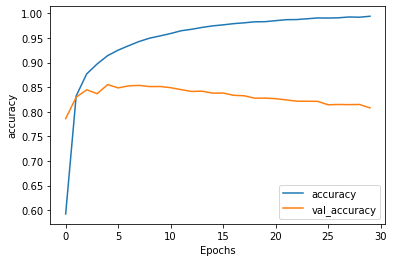

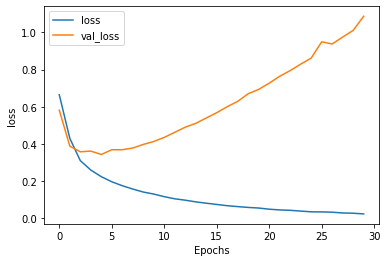

In [40]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()


plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [41]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])


def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [42]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)  # shape: (vocab_size, embedding_dim)

(10000, 16)


In [43]:
sentence = ["granny starting to fear spiders in the garden might be real",
            "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[8.8503045e-01]
 [1.7602473e-05]]


# imdb

In [1]:
import tensorflow_datasets as tfds

imdb, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

In [2]:
train_data, test_data = imdb['train'], imdb['test']

In [3]:
tokenizer = info.features['text'].encoder

In [4]:
print(tokenizer.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

In [5]:
sample_string = 'TensorFlow, from basics to mastery'

tokenized_string = tokenizer.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print('The original string: {}'.format(original_string))

Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: TensorFlow, from basics to mastery


In [6]:
for ts in tokenized_string:
    print('{} ----> {}'.format(ts, tokenizer.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


In [9]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_data.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_data.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))

In [13]:
embedding_dim = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          523840    
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
________________________________________________

In [14]:
num_epochs = 10

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 4s 9ms/step - loss: 0.6751 - accuracy: 0.6063 - val_loss: 0.6239 - val_accuracy: 0.7411
Epoch 2/10
391/391 [==============================] - 3s 8ms/step - loss: 0.5211 - accuracy: 0.7942 - val_loss: 0.4441 - val_accuracy: 0.8418
Epoch 3/10
391/391 [==============================] - 3s 8ms/step - loss: 0.3693 - accuracy: 0.8658 - val_loss: 0.3539 - val_accuracy: 0.8650
Epoch 4/10
391/391 [==============================] - 3s 8ms/step - loss: 0.2931 - accuracy: 0.8927 - val_loss: 0.3244 - val_accuracy: 0.8712
Epoch 5/10
391/391 [==============================] - 3s 8ms/step - loss: 0.2522 - accuracy: 0.9092 - val_loss: 0.3088 - val_accuracy: 0.8798
Epoch 6/10
391/391 [==============================] - 3s 8ms/step - loss: 0.2280 - accuracy: 0.9164 - val_loss: 0.3077 - val_accuracy: 0.8804
Epoch 7/10
391/391 [==============================] - 3s 8ms/step - loss: 0.2081 - accuracy: 0.9233 - val_loss: 0.3153 - val_accuracy: 0.8764
Epoch 

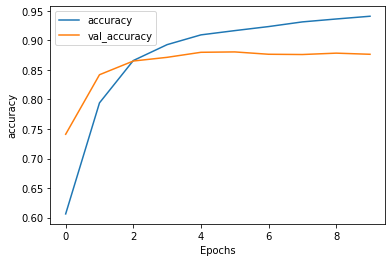

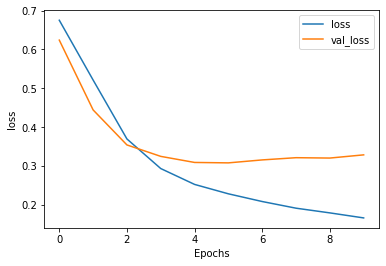

In [15]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()


plot_graphs(history, "accuracy")
plot_graphs(history, "loss")